In [1]:
'''
import library 
'''
!pip install -U opencv-contrib-python==3.4.0.12
import numpy as np
import cv2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 30.5MB 152kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
  """
  compute the homography transform
  p1, p2: 4 x 2, 4 groups of corresponding points
  """	
  # IMPLEMENT HERE, hint: you may find np.linalg.svd useful
  
  # construct the A matrix in the same way in the slides
  A = [[p2[0][0],p2[0][1],1,0,0,0,-p2[0][0]*p1[0][0],-p2[0][1]*p1[0][0],-p1[0][0]],
       [0,0,0,p2[0][0],p2[0][1],1,-p2[0][0]*p1[0][1],-p2[0][1]*p1[0][1],-p1[0][1]],
       [p2[1][0],p2[1][1],1,0,0,0,-p2[1][0]*p1[1][0],-p2[1][1]*p1[1][0],-p1[1][0]],
       [0,0,0,p2[1][0],p2[1][1],1,-p2[1][0]*p1[1][1],-p2[1][1]*p1[1][1],-p1[1][1]],
       [p2[2][0],p2[2][1],1,0,0,0,-p2[2][0]*p1[2][0],-p2[2][1]*p1[2][0],-p1[2][0]],
       [0,0,0,p2[2][0],p2[2][1],1,-p2[2][0]*p1[2][1],-p2[2][1]*p1[2][1],-p1[2][1]],
       [p2[3][0],p2[3][1],1,0,0,0,-p2[3][0]*p1[3][0],-p2[3][1]*p1[3][0],-p1[3][0]],
       [0,0,0,p2[3][0],p2[3][1],1,-p2[3][0]*p1[3][1],-p2[3][1]*p1[3][1],-p1[3][1]]
       ]
  # use SVD to find the solution to Ax = 0
  u,s,vh = np.linalg.svd(A)
  # reorgnize the solution vector and normalize it to get homography matrix
  v = vh.T
  h = v[:,-1]/v[-1,-1]
  H = h.reshape(3,3)
  #print(H)
  return H

In [3]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ [115.0000,  120.0000],
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)
assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [4]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [5]:
'''
Function (modify)
'''
def match_features(f1,f2):
  """
  f1, f2: N * feature_size, two features to be matched
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful

  N = f1.shape[0]
  M = f2.shape[0]

  # compute pairwise distance between f1 and f2
  dist = cdist(f1,f2)
  f1_dist = np.argsort(dist)
  f2_dist = np.argsort(dist,0)

  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  match_fwd = []
  min_f1 = f1_dist[:,0]
  second_f1 = f1_dist[:,1]
  for i in range (0,N):
    if ((dist[i,min_f1[i]] / dist[i, second_f1[i]]) < 0.7):
      match_fwd.append([i,min_f1[i]])
  match_fwd = np.array(match_fwd)

  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  match_bkwd = []
  min_f2 = f2_dist[0]
  second_f2 = f2_dist[1]
  for j in range (0, M):
    if ((dist[min_f2[j],j]/dist[second_f2[j],j]) < 0.7):
      match_bkwd.append([min_f2[j],j])
  match_bkwd = np.array(match_bkwd)
  
  # get the intersect of two matching as the final result with python set 
  set1 = set(map(tuple, match_fwd))
  set2 = set(map(tuple, match_bkwd))
  intersect = set1 & set2
  match = np.array(list(intersect))

  return match, match_fwd, match_bkwd

In [6]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

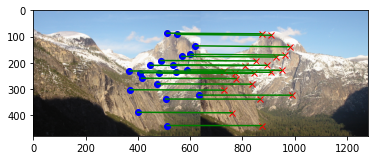

In [8]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [14]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
  """
  p1, p2: N * 2, correponding point coordinates
  """
  
  # IMPLEMENT HERE
  
  # decide how many loops to run and what the threshold is
  import math
  w = 0.5
  p = 1-10**(-4)
  n = 4
  threshold = math.sqrt(2)
  iterations = math.ceil(math.log(1-p)/math.log(1-w**n))
  
  # RANSAC loop, inside in the loop
  nbest = 0
  for i in range (0,iterations):

  #     1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
    rd = np.random.choice(p1.shape[0],4)
    
    p1_sample = [p1[rd[0]],p1[rd[1]],p1[rd[2]],p1[rd[3]]]
    p2_sample = [p2[rd[0]],p2[rd[1]],p2[rd[2]],p2[rd[3]]]
    
  #     2. fit the model and get a estimation
    H = compute_homography (p1_sample,p2_sample)
   
  #     3. count consensus(# of inliners that is close to the estimatiion within the threshold)
    inliners = 0
    projected=[]
    for k in range(0,p1.shape[0]):
      temp = H.dot(np.array([p2[k][0],p2[k][1],1]))
      temp = temp/temp[2]
      projected.append(temp)
    projected = np.array(projected)
    
    for k in range(0,p1.shape[0]):
      distance = math.sqrt((p1[k][0]-projected[k][0])**2 + (p1[k][1]-projected[k][1])**2)
      if (distance <= threshold):
        inliners+=1  
  
  #     4. update the best estimation if the current one is better 
    if (inliners>=nbest):
      nbest = inliners
      best_H = H
  return best_H

In [10]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

In [11]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    eps = 1e-7
    sy1, sx1, sz1 = I1.shape
    sy2, sx2, sz2 = I2.shape
    x2, y2 = np.meshgrid(np.arange(sx2), np.arange(sy2))
    # map I2 to I1
    p1_hat = H @ np.r_[x2.ravel(), y2.ravel(), np.ones_like(x2.ravel())].reshape(3, -1)
    p1_hat = p1_hat[0:2] / (p1_hat[2] + eps)

    # create new dimensions to accomodate points from I2
    p1_hat_xmax = np.max(p1_hat[0])
    p1_hat_xmin = np.min(p1_hat[0])
    p1_hat_ymax = np.max(p1_hat[1])
    p1_hat_ymin = np.min(p1_hat[1])

    xmin = np.rint(np.floor(np.minimum(p1_hat_xmin, 0))).astype(np.int32)
    xmax = np.rint(np.ceil(np.maximum(p1_hat_xmax, sx2))).astype(np.int32)
    ymin = np.rint(np.floor(np.minimum(p1_hat_ymin, 0))).astype(np.int32)
    ymax = np.rint(np.ceil(np.maximum(p1_hat_ymax, sy2))).astype(np.int32)

    # create images for mapping
    I1_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I2_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)

    # I1 is just translated in I_
    I1_[-ymin:sy1 - ymin, -xmin:sx1 - xmin, :] = I1[:min(sy1, ymax), :min(sx1, xmax), :]

    # map I_ to I2 (translation then homography)
    sy2_, sx2_, sz2_ = I2_.shape
    x2_, y2_ = np.meshgrid(np.arange(sx2_), np.arange(sy2_))
    p2_hat = np.linalg.inv(H) @ np.r_[x2_.ravel() + xmin, y2_.ravel() + ymin, np.ones(x2_.size)].reshape(3, -1)
    p2_hat = np.rint(p2_hat[0:2] / (p2_hat[2] + eps)).astype(np.int32)

    # keep only the valid coordinates of I2
    good_x = np.logical_and(p2_hat[0, :] >= 0, p2_hat[0, :] < sx2)
    good_y = np.logical_and(p2_hat[1, :] >= 0, p2_hat[1, :] < sy2)
    good = np.logical_and(good_x, good_y)


    # I2 transformed by homography in I_
    I2_[y2_[good.reshape(x2_.shape)], x2_[good.reshape(x2_.shape)]] = I2[p2_hat[1, good], p2_hat[0, good]]

    # nonoverlapping regions do not require blending
    I2_sum = np.sum(I2_, axis=2)
    I1_sum = np.sum(I1_, axis=2)

    # in no blend area, one of I1_ and I2_ is all 0 
    no_blend_area = np.logical_or(I2_sum == 0, I1_sum == 0)
    I_[no_blend_area] = I2_[no_blend_area] + I1_[no_blend_area]

    # in blend area, take the average of I1_ and I2_
    blend_area = np.logical_and(I2_sum > 0, I1_sum > 0)
    I_[blend_area] = (I1_[blend_area] * .5 + I2_[blend_area] * .5).astype(np.uint8)
    return I_

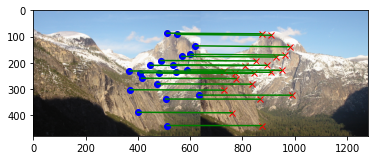

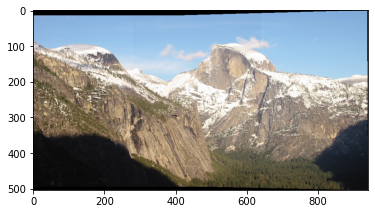

In [12]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.show()

[[ 2.00286517e+00  5.87359766e-03  1.88539322e+00]
 [-1.62775937e-13  2.00737781e+00  2.91404491e+00]
 [-4.07860915e-15  7.16292398e-05  1.00000000e+00]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


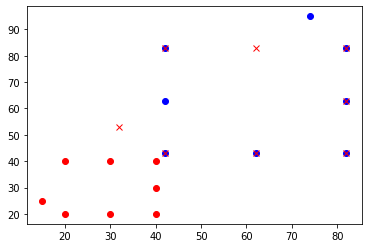

In [13]:
p2= np.array([[20, 20],
              [20, 30],
              [20, 40],
              [40, 20],
              [40, 30],
              [40, 40],
              [30, 20],
              [30, 40]])

p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T

H = np.array([[2,  0,  2],
              [0,  2,  3],
              [0,  0,  1]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 12 # add noise
p1 = p1.T

p2[1, :] -=5 # add noise
plt.plot(p2[:, 0], p2[:, 1], 'ro')
plt.plot(p1[:, 0], p1[:, 1], 'bo')

H_hat = ransac_homography(p1, p2)
print(H_hat)
p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T
p1_hat_ = H_hat @ p2_
p1_hat = p1_hat_ / p1_hat_[-1, :]
p1_hat = p1_hat[:2]
p1_hat = p1_hat.T
plt.plot(p1_hat[:, 0], p1_hat[:, 1], 'rx')